In [1]:
from time import time
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

from sklearn.metrics import mean_squared_error, r2_score

import seaborn as sns
import sys
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
from matplotlib.animation import FuncAnimation
from matplotlib import rc

from math import sqrt
SPINE_COLOR = 'gray'
p = print

window = 24

In [2]:
def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9 # width in inches

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'text.latex.preamble': [r'\usepackage{gensymb}'],
              'axes.labelsize': 10, # fontsize for x and y labels (was 10)
              'axes.titlesize': 10,
              'font.size': 10, # was 10
              'legend.fontsize': 10, # was 10
              'xtick.labelsize': 10,
              'ytick.labelsize': 10,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)

def format_axes(ax):

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

### Checking RMSE

In [101]:
Models = [['GP+MI', 'gpmi'],
          ['GP+Uncertainty', 'gpvar'], 
          ['GP+Random', 'gprand'],
          ['RF+Random', 'rfrand'],
          ['KN+R', 'knnrand'],
          ['SV+R', 'svrrand'],
          ['QBC', 'qbc']]

n_seed = 10
key = ''
res_dict_pred = {name:np.random.rand(n_seed,276,6)*np.nan for name,_ in Models}
res_dict_test = {'test':np.random.rand(n_seed,276,6)*np.nan}
for seed in range(n_seed):
    for name, file in Models:
#         print(pd.read_pickle(file+str(seed)+'kmeans'+'.pred').shape)
        res_dict_pred[name][seed,:,:] = pd.read_pickle(file+str(seed)+key+'.pred')
    res_dict_test['test'][seed,:,:] = pd.read_pickle('testdf'+str(seed)+key+'.pickle')

for name in res_dict_pred:
    p(name, np.sqrt(np.square(res_dict_pred[name] - res_dict_test['test']).mean(axis=1)).mean())

GP+MI 33.80166742764872
GP+Uncertainty 33.96924083050149
GP+Random 34.40825776288057
RF+Random 31.677269229151413
KN+R 33.11442579997983
SV+R 31.42140710146224
QBC 30.857793056043658


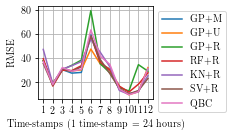

In [102]:
agg = {name:[] for name in res_dict_pred.keys()}
for i in range(0,276,window):
    for name in res_dict_pred.keys():
        if 'gpr' not in name.lower():
            tmp = []
            for seed in [8]:
                tmp.append(mean_squared_error(res_dict_test['test'][seed,i:i+window,:].ravel(), 
                         res_dict_pred[name][seed,i:i+window,:].ravel(), squared=False))
        agg[name].append(np.mean(tmp))

latexify(3.32,2)
for name in agg:
    if 'gpr' not in name.lower():
        plt.plot(range(1,13), agg[name], label=name[:4])
plt.xticks(range(1,13));
plt.grid(True)
plt.xlabel('Time-stamps (1 time-stamp = 24 hours)')
plt.ylabel('RMSE')
plt.legend(bbox_to_anchor=(1,1));
plt.tight_layout();
plt.savefig('imgs/Beijing_random_seed_6.pdf')

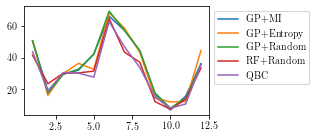

In [298]:
agg = {name:[] for name in res_dict_pred.keys()}
for i in range(0,276,window):
    for name in res_deploy_dict.keys():
        tmp = []
        for seed in [3]:
            tmp.append(mean_squared_error(res_dict_test['test'][seed,i:i+window,:].ravel(), 
                         res_dict_pred[name][seed,i:i+window,:].ravel(), squared=False))
        agg[name].append(np.mean(tmp))

latexify(3.32,2)
for name in agg:
    plt.plot(range(1,13), agg[name], label=name)
plt.legend(bbox_to_anchor=(1,1));

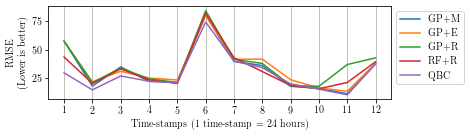

In [258]:
mean_srmse_dict = {name:np.random.rand(6,12)*np.nan for name in res_dict.keys()}
seed = 4
srmse_dict = {name:[] for name in res_dict.keys()}
for name, res in res_dict.items():
    for i in range(0,276,window):
        srmse_dict[name].append(np.sqrt(np.square(res_dict_pred[name][seed,i:i+window,:] - res_dict_test['test'][seed,i:i+window,:]).mean()))

latexify(3.32*2, 2)
fig, ax = plt.subplots()

for name in mean_srmse_dict:
    mean_srmse_dict[name] = np.mean(mean_srmse_dict[name], axis=0)
    ax.plot(range(1,12+1), srmse_dict[name], '-', label=name[:4])

ax.set_ylabel('RMSE\n(Lower is better)')
ax.set_xlabel('Time-stamps (1 time-stamp = 24 hours)')
ax.legend(bbox_to_anchor=(1,1));
ax.set_xticks(range(1,12+1))
fig.tight_layout()
ax.grid(True, axis='x')
fig.savefig('imgs/compare.pdf')

### Result DataFrame

### Checking placements

In [253]:
res_deploy_dict = {name:None for name in res_dict.keys()}

for name, file in Models:
    res_deploy_dict[name] = pd.read_pickle(file+str(seed)+'.dep')

In [254]:
data_df = pd.read_pickle('../data_and_results/u-air/production/pm25_beijing_best36/linear/linear_df.pickle')
all_locs = data_df[['longitude', 'latitude', 'station_id']].drop_duplicates()
all_locs.head(2)

,longitude,latitude,station_id
time,,,
2013-11-08 14:26:00,116.173553,40.09068,1001
2013-11-08 14:26:00,116.205311,40.00395,1002


In [255]:
global_test_stations = pd.read_pickle('global_test'+str(seed)+'.station')
global_train_stations = pd.read_pickle('global_train'+str(seed)+'.station')

GP+MI
GP+Entropy
GP+Random
RF+Random
QBC


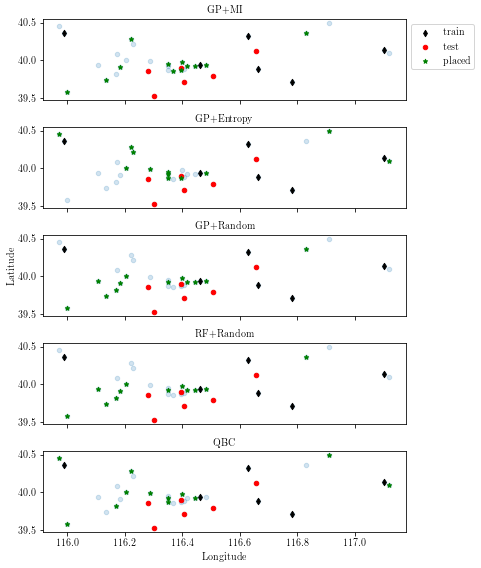

In [256]:
latexify(3.32*2, 8)
fig, ax = plt.subplots(5,1,sharex=True, sharey=True)

tst_locs = all_locs[all_locs.station_id.isin(global_test_stations)][['longitude', 'latitude']].values
train_locs = all_locs[all_locs.station_id.isin(global_train_stations)][['longitude', 'latitude']].values

ss = 20

for i in range(5):
    print(Models[i][0])
    ax[i].scatter(all_locs.values[:,0], all_locs.values[:,1], alpha=0.2, s=ss)
    ax[i].scatter(train_locs[:,0], train_locs[:,1], s=ss, c='k', marker='d', label='train')
    ax[i].scatter(tst_locs[:,0], tst_locs[:,1], s=ss, c='red', label='test')
    dep_locs = all_locs[all_locs.station_id.isin(res_deploy_dict[Models[i][0]])][['longitude', 'latitude']].values
    ax[i].scatter(dep_locs[:,0], dep_locs[:,1], s=ss, c='g', marker='*', label='placed')
    ax[i].set_title(Models[i][0])

ax[0].legend(bbox_to_anchor=(1,1))
ax[-1].set_xlabel('Longitude')
fig.text(0,0.5,'Latitude', rotation=90)
fig.tight_layout()
fig.savefig('imgs/alllocs.pdf')